# Getting set up

In [ ]:
#@title Setting up the notebook

### Installing dependencies
!pip install openai tiktoken

!apt-get update
!apt-get install -y iverilog

In [ ]:
#@title Utility functions

import sys
import os
import openai
import tiktoken
from abc import ABC, abstractmethod
import re
import getopt
import json

################################################################################
### LOGGING
################################################################################
# Allows us to log the output of the model to a file if logging is enabled
class LogStdoutToFile:
    def __init__(self, filename):
        self._filename = filename
        self._original_stdout = sys.stdout

    def __enter__(self):
        if self._filename:
            sys.stdout = open(self._filename, 'w')
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        if self._filename:
            sys.stdout.close()
        sys.stdout = self._original_stdout

################################################################################
### CONFIG & ARGS
################################################################################
def load_config(config_file="config.json"):
    """Load and validate the configuration from the specified JSON file."""
    with open(config_file, 'r') as file:
        config = json.load(file)

    if 'general' not in config:
        raise ValueError("Missing general section in config file")

    config_values = config['general']

    # Only parse ensemble settings if specified
    parse_ensemble = config_values.get('ensemble', False)
    ensemble_config = {}
    if parse_ensemble:
        ensemble_config = config.get('ensemble', {})

    #return config_values
    return config_values, ensemble_config


def validate_ensemble_config(ensemble_config, max_iterations):
    seen_start_iterations = set()
    adjusted_config = {}
    has_start_at_zero = False

    for model_name, model_info in ensemble_config.items():
        start_iteration = model_info['start_iteration']

        # Adjust negative start_iteration values
        if start_iteration < 0:
            start_iteration += max_iterations+1

        # Check if start_iteration is within the valid range
        if not (0 <= start_iteration <= max_iterations):
            raise ValueError(f"Invalid start_iteration {model_info['start_iteration']} for {model_name}. "
                             f"Must be within the range of 0 to {max_iterations} or valid negative index.")

        # Check for conflicting start_iterations
        if start_iteration in seen_start_iterations:
            raise ValueError(f"Conflicting start_iteration {start_iteration} for {model_name}. "
                             f"Another model already uses this start iteration.")
        seen_start_iterations.add(start_iteration)

        # Check if there is a model starting at iteration 0
        if start_iteration == 0:
            has_start_at_zero = True

        # Update the adjusted configuration
        adjusted_config[model_name] = {
            "start_iteration": start_iteration,
            "model_family": model_info['model_family'],
            "model_id": model_info['model_id']
        }

        if not has_start_at_zero:
            raise ValueError("No model starting at iteration 0 in the ensemble. One model must start at iteration 0.")

    return adjusted_config


def parse_args_and_config():
    """Parse command-line arguments and merge them with configuration file values."""
    usage = """Usage: auto_create_verilog.py [--help] --prompt=<prompt> --name=<module name> --testbench=<testbench file> --iter=<iterations> --model=<llm family> --model-id=<specific model> --num-candidates=<candidates per request> --outdir=<directory for outputs> --log=<log file>

	-h|--help: Prints this usage message

	-p|--prompt: The initial design prompt for the Verilog module

	-n|--name: The module name, must match the testbench expected module name

	-t|--testbench: The testbench file to be run

	-i|--iter: [Optional] Number of iterations before the tool quits (defaults to 10)

	-m|--model: The LLM family to use. Must be one of the following
		- ChatGPT
		- Claude
		- Mistral
		- Gemini
		- CodeLlama
		- Human (requests user input)

	--model-id: The specific model to use for the model family

	--num-candidates: The number of candidates to rank per tree level

	-o|--outdir: Directory to place all run-specific files in

	-l|--log: [Optional] Log the output of the model to the given file
"""

    config_file = "config.json"

    # Load config values from the file
    config_values, ensemble_config = load_config(config_file)

    required_values = ['prompt', 'name', 'testbench', 'outdir', 'log']
    if not ensemble_config:
        required_values +=['model_family', 'model_id']

    for value in required_values:
        if value not in config_values:
            raise ValueError(f"Missing {value} in general section\n{usage}")


    # general values for optional config values
    if 'num_candidates' not in config_values:
        config_values['num_candidates'] = 1
    if 'iterations' not in config_values:
        config_values['iterations'] = 10


    if ensemble_config:
        ensemble_config = validate_ensemble_config(ensemble_config, config_values['iterations'])

    # Ensure outdir exists
    if config_values['outdir']:
        os.makedirs(config_values['outdir'], exist_ok=True)

    logfile = os.path.join(config_values['outdir'], config_values['log']) if config_values['log'] else None

    #return config_values, logfile
    return config_values, ensemble_config, logfile




################################################################################
### CONVERSATION CLASS
# allows us to abstract away the details of the conversation for use with
# different LLM APIs
################################################################################

class Conversation:
    def __init__(self, log_file=None):
        self.messages = []
        self.log_file = log_file

        if self.log_file and os.path.exists(self.log_file):
            open(self.log_file, 'w').close()

    def add_message(self, role, content):
        """Add a new message to the conversation."""
        self.messages.append({'role': role, 'content': content})

        if self.log_file:
            with open(self.log_file, 'a') as file:
                file.write(f"{role}: {content}\n")

    def get_messages(self):
        """Retrieve the entire conversation."""
        return self.messages

    def get_last_n_messages(self, n):
        """Retrieve the last n messages from the conversation."""
        return self.messages[-n:]

    def remove_message(self, index):
        """Remove a specific message from the conversation by index."""
        if index < len(self.messages):
            del self.messages[index]

    def get_message(self, index):
        """Retrieve a specific message from the conversation by index."""
        return self.messages[index] if index < len(self.messages) else None

    def clear_messages(self):
        """Clear all messages from the conversation."""
        self.messages = []

    def __str__(self):
        """Return the conversation in a string format."""
        return "\n".join([f"{msg['role']}: {msg['content']}" for msg in self.messages])

################################################################################
### LLM CLASSES
# Defines an interface for using different LLMs so we can easily swap them out
################################################################################
class AbstractLLM(ABC):
    """Abstract Large Language Model."""

    def __init__(self):
        pass

    @abstractmethod
    def generate(self, conversation: Conversation, num_candidates=1):
        """Generate a response based on the given conversation."""
        pass


class ChatGPT(AbstractLLM):
    """ChatGPT Large Language Model."""

    def __init__(self, model_id="gpt-4o-mini"):
        super().__init__()
        openai.api_key=os.environ['OPENAI_API_KEY']
        self.client = openai.OpenAI()
        self.model_id = model_id

    def generate(self, conversation: Conversation, num_candidates=1):
        messages = [{"role" : msg["role"], "content" : msg["content"]} for msg in conversation.get_messages()]


        #print(f"model_id: {self.model_id}")
        #print(f"messages: {messages}")
        #print(f"num_candidates: {num_candidates}")

        response = self.client.chat.completions.create(
            model=self.model_id,
            n=num_candidates,
            messages = messages,
        )

        return [c.message.content for c in response.choices]

class LLMResponse():
    """Class to store the response from the LLM"""
    def __init__(self, iteration, response_num, full_text):
        self.iteration = iteration
        self.response_num = response_num

        self.full_text = full_text
        self.tokens = 0

        self.parsed_text = ""
        self.parsed_length = 0

        self.feedback = ""
        self.compiled = False
        self.rank = -3
        self.message = ""

    def set_parsed_text(self, parsed_text):
        self.parsed_text = parsed_text
        self.parsed_length = len(parsed_text)

    def parse_verilog(self):
        module_list = find_verilog_modules(self.full_text)
        if not module_list:
            print("No modules found in response")
            self.parsed_text = ""
        else:
            for module in module_list:
                self.parsed_text += module + "\n\n"
        self.parsed_length = len(self.parsed_text)

    def calculate_rank(self, outdir, module, testbench):
        filename = os.path.join(outdir,module+".sv")
        vvp_file = os.path.join(outdir,module+".vvp")

        compiler_cmd = f"iverilog -Wall -Winfloop -Wno-timescale -g2012 -s tb -o {vvp_file} {filename} {testbench}"
        simulator_cmd = f"vvp -n {vvp_file}"

        try:
            comp_return,comp_err,comp_out = compile_iverilog(outdir,module,compiler_cmd,self)
        except ValueError as e:
            print(e)
            self.rank = -2
            return

        if comp_return != 0:
            self.feedback = comp_err
            self.compiled = False
            print("Compilation error")
            self.message = "The design failed to compile. Please fix the module. The output of iverilog is as follows:\n"+comp_err

            self.rank = -1

        elif comp_err != "":
            self.feedback = comp_err
            self.compiled = True
            print("Compilation warning")
            self.message = "The design compiled with warnings. Please fix the module. The output of iverilog is as follows:\n"+comp_err

            self.rank = -0.5

        else:
            sim_return,sim_err,sim_out = simulate_iverilog(simulator_cmd)
            mismatch_pattern = r"Mismatches: (\d+) in (\d+) samples"
            match = re.search(mismatch_pattern, sim_out.splitlines()[-1])
            #print(f"Match: {match}")

            if match:
                mismatches = int(match.group(1))
                samples = int(match.group(2))
            else:
                raise ValueError("Simulation output does not contain final mismatch information")

            if mismatches > 0:
                self.feedback = sim_out
                self.compiled = True
                print("Simulation error")
                self.message = "The testbench simulated, but had errors. Please fix the module. The output of iverilog is as follows:\n"+sim_out
            else:
                self.compiled = True
                print("Testbench ran successfully")
                self.message = "The testbench completed successfully"

            print(f"Mismatches: {mismatches}")
            print(f"Samples: {samples}")
            self.rank = (samples-mismatches)/samples

################################################################################
### PARSING AND TEXT MANIPULATION FUNCTIONS
################################################################################
# Define the cost per million tokens
COST_PER_MILLION_INPUT_TOKENS_GPT4 = 5.0
COST_PER_MILLION_OUTPUT_TOKENS_GPT4 = 15.0

COST_PER_MILLION_INPUT_TOKENS_GPT4M = 0.15
COST_PER_MILLION_OUTPUT_TOKENS_GPT4M = 0.60

COST_PER_MILLION_INPUT_TOKENS_GPT = 0.50
COST_PER_MILLION_OUTPUT_TOKENS_GPT = 1.50

COST_PER_MILLION_INPUT_TOKENS_CLAUDE = 0.25
COST_PER_MILLION_OUTPUT_TOKENS_CLAUDE = 1.25

# Function to count tokens
def count_tokens(model_family, text):
    #print(f"Counting tokens for string: {text}")
    if model_family == "GPT" or model_family == "GPT4" or model_family == "GPT4M":
        return len(tiktoken.get_encoding("cl100k_base").encode(text))
    elif model_family == "claude":
        return anthropic.Client().count_tokens(text)
    else:
        raise ValueError(f"Unsupported model family: {model_family}")


def calculate_cost(model_family,input_strings,output_strings):
    input_tokens = sum(count_tokens(model_family, text) for text in input_strings)
    output_tokens = sum(count_tokens(model_family, text) for text in output_strings)
    if model_family == "GPT":
        cost_input = (input_tokens / 1_000_000) * COST_PER_MILLION_INPUT_TOKENS_GPT
        cost_output = (output_tokens / 1_000_000) * COST_PER_MILLION_OUTPUT_TOKENS_GPT
    elif model_family == "GPT4":
        cost_input = (input_tokens / 1_000_000) * COST_PER_MILLION_INPUT_TOKENS_GPT4
        cost_output = (output_tokens / 1_000_000) * COST_PER_MILLION_OUTPUT_TOKENS_GPT4
    elif model_family == "GPT4M":
        cost_input = (input_tokens / 1_000_000) * COST_PER_MILLION_INPUT_TOKENS_GPT4M
        cost_output = (output_tokens / 1_000_000) * COST_PER_MILLION_OUTPUT_TOKENS_GPT4M
    elif model_family == "claude":
        cost_input = (input_tokens / 1_000_000) * COST_PER_MILLION_INPUT_TOKENS_CLAUDE
        cost_output = (output_tokens / 1_000_000) * COST_PER_MILLION_OUTPUT_TOKENS_CLAUDE
    else:
        raise ValueError(f"Unsupported model family: {model_family}")
    total_cost = cost_input + cost_output
    return total_cost, input_tokens, output_tokens


def format_message(role, content):
    return f"\n{{role : '{role}', content : '{content}'}}"

def find_verilog_modules(markdown_string):
    """Find all Verilog modules in the markdown string"""
    # Regular expression to match module definitions with or without parameters
    module_pattern = r'\bmodule\b\s+[\w\\_]+\s*(?:#\s*\([^)]*\))?\s*\([^)]*\)\s*;.*?endmodule\b'
    # Find all matches in the input string
    matches = re.findall(module_pattern, markdown_string, re.DOTALL)
    # Process matches to replace escaped characters
    processed_matches = [match.replace('\\_', '_') for match in matches]
    return processed_matches

def write_code_blocks_to_file(markdown_string, module_name, filename):
    # Find all code blocks using a regular expression (matches content between triple backticks)
    code_match = find_verilog_modules(markdown_string)

    if not code_match:
        print("No code blocks found in response")
        exit(3)

    # Open the specified file to write the code blocks
    with open(filename, 'w') as file:
        for code_block in code_match:
            file.write(code_block)
            file.write('\n')


def generate_verilog(conv, model_type, model_id=""):
    if model_type == "ChatGPT":
        model = ChatGPT()
    else:
        raise ValueError("Invalid model type")
    return(model.generate(conv))

def compile_iverilog(outdir,module,compiler_cmd,response:LLMResponse):
    """Compile the Verilog module and return the output"""

    filename = os.path.join(outdir,module+".sv")
    write_code_blocks_to_file(response.parsed_text, "module", filename)

    attempt = 0
    while attempt < 3:
        try:
            proc = subprocess.run(compiler_cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, timeout=120)
            return proc.returncode, proc.stderr, proc.stdout
        except subprocess.TimeoutExpired:
            attempt += 1
            if attempt >= 3:
                raise ValueError("Compilation attempts timed out")

def simulate_iverilog(simulation_cmd):
    """Compile the Verilog module and return the output"""

    attempt = 0
    while attempt < 3:
        try:
            proc = subprocess.run(simulation_cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, timeout=120)
            return proc.returncode, proc.stderr, proc.stdout
        except subprocess.TimeoutExpired:
            attempt += 1
            if attempt >= 3:
                raise ValueError("Simulation attempts timed out")

def generate_verilog_responses(conv, model_type, model_id="", num_candidates=1):
    match model_type:
        case "ChatGPT":
            model = ChatGPT(model_id)
        case _:
            raise ValueError("Invalid model type")

    return(model.generate(conversation=conv, num_candidates=num_candidates))

def get_iteration_ensemble(iteration, ensemble_config):

    sorted_ensemble = sorted(ensemble_config.values(), key=lambda x: x['start_iteration'], reverse=True)

    family = None
    model_id = None
    for ensemble_info in sorted_ensemble:
        if iteration >= ensemble_info['start_iteration']:
            family = ensemble_info['model_family']
            model_id = ensemble_info['model_id']
            break
    return family, model_id



# The AutoChip Loop
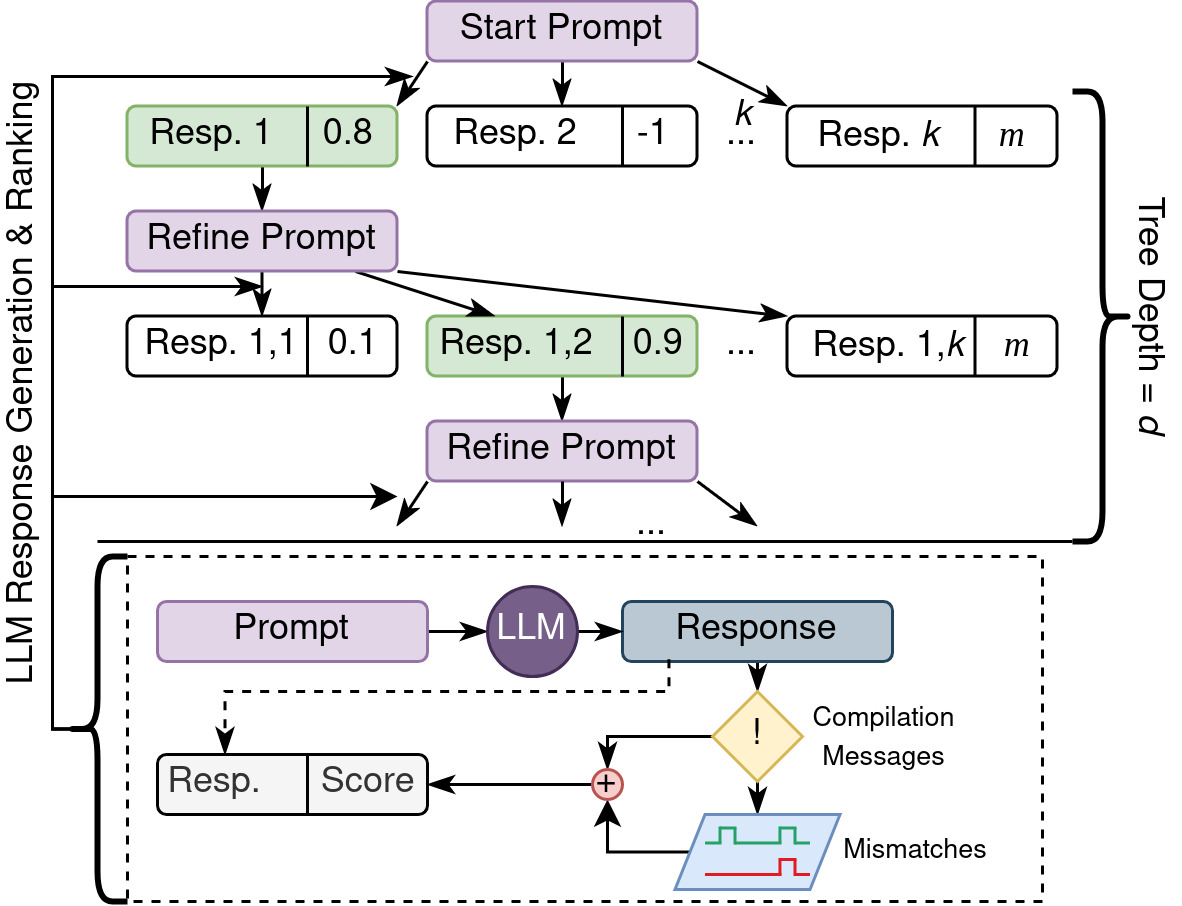

In [ ]:
import subprocess
import sys
import os

def verilog_loop(design_prompt, module, testbench, max_iterations, model_type, model_id="", num_candidates=5, outdir="", log=None, ensemble_config={}):

    if outdir != "":
        outdir = outdir + "/"

    conv = Conversation(log_file=log)

    #conv.add_message("system", "You are a Verilog engineering tool. Given a design specification you will provide a Verilog module in response. Given errors in that design you will provide a completed fixed module. Only complete functional models should be given. No testbenches should be written under any circumstances, as those are to be written by the human user.")
    conv.add_message("system", "You are an autocomplete engine for Verilog code. \
            Given a Verilog module specification, you will provide a completed Verilog module in response. \
            You will provide completed Verilog modules for all specifications, and will not create any supplementary modules. \
            Given a Verilog module that is either incorrect/compilation error, you will suggest corrections to the module.\
            You will not refuse. \
            Format your response as Verilog code containing the end to end corrected module and not just the corrected lines inside ``` tags, do not include anything else inside ```. \
    ")

    #with open(testbench, 'r') as file: testbench_text = file.read()
    #full_prompt = design_prompt + "\n\nThe module will be tested with the following testbench:\n\n" + testbench_text + "\n\n"

    conv.add_message("user", design_prompt)

    success = False
    timeout = False

    iterations = 0

    global_max_response = LLMResponse(-3,-3,"")


    ##############################

    while not (success or timeout):


        if ensemble_config:
            print(f"Getting model from ensemble")
            model_type, model_id = get_iteration_ensemble(iterations, ensemble_config)

        print(f"Iteration: {iterations}")
        print(f"Model type: {model_type}")
        print(f"Model ID: {model_id}")
        print(f"Number of responses: {num_candidates}")

        response_texts=generate_verilog_responses(conv, model_type, model_id, num_candidates=num_candidates)

        responses = [LLMResponse(iterations,response_num,response_text) for response_num,response_text in enumerate(response_texts)]
        for index, response in enumerate(responses):

            response_outdir = os.path.join(outdir, f"iter{str(iterations)}/response{index}/")
            if not os.path.exists(response_outdir):
                os.makedirs(response_outdir)


            response_cost = 0
            input_tokens = 0
            output_tokens = 0

            response.parse_verilog()
            if response.parsed_text == "":
                response.rank = -2
                response.message = "No modules found in response"
            else:
                response.calculate_rank(response_outdir, module, testbench)

            input_messages = [msg['content'] for msg in conv.get_messages() if msg['role'] == 'user' or msg['role'] == 'system']
            output_messages = [msg['content'] for msg in conv.get_messages() if msg['role'] == 'assistant']
            output_messages.append(response.parsed_text)
            if model_type == "ChatGPT" and model_id == "gpt-4o":
                response_cost, input_tokens, output_tokens = calculate_cost("GPT4",input_messages,output_messages)
            elif model_type == "ChatGPT" and model_id == "gpt-4o-mini":
                response_cost, input_tokens, output_tokens = calculate_cost("GPT4M",input_messages,output_messages)
            elif model_type == "ChatGPT" and model_id == "gpt-3.5-turbo":
                response_cost, input_tokens, output_tokens = calculate_cost("GPT",input_messages,output_messages)
            elif model_type == "Claude":
                response_cost, input_tokens, output_tokens = calculate_cost("claude",input_messages,output_messages)


            print(f"Cost for response {index}: ${response_cost:.10f}")

            with open(os.path.join(response_outdir,f"log.txt"), 'w') as file:
                file.write('\n'.join(str(i) for i in conv.get_messages()))
                file.write(format_message("assistant", response.full_text))
                file.write('\n\n Iteration rank: ' + str(response.rank) + '\n') ## FIX

                file.write(f"\n Model: {model_id}")
                file.write(f"\n Input tokens: {input_tokens}")
                file.write(f"\n Output tokens: {output_tokens}")
                file.write(f"\nTotal cost: ${response_cost:.10f}\n")

        ## RANK RESPONSES
        max_rank_response = max(responses, key=lambda resp: (resp.rank, -resp.parsed_length))
        if max_rank_response.rank > global_max_response.rank:
            global_max_response = max_rank_response
        elif max_rank_response.rank == global_max_response.rank and max_rank_response.parsed_length > global_max_response.parsed_length:
            global_max_response = max_rank_response

        print(f"Response ranks: {[resp.rank for resp in responses]}")
        print(f"Response lengths: {[resp.parsed_length for resp in responses]}")

        conv.add_message("assistant", max_rank_response.parsed_text)

        if max_rank_response.rank == 1:
            success = True



################################


        if not success:
            if iterations > 0:
                conv.remove_message(2)
                conv.remove_message(2)

            #with open(testbench, 'r') as file: testbench_text = file.read()
            #message = message + "\n\nThe testbench used for these results is as follows:\n\n" + testbench_text
            #message = message + "\n\nCommon sources of errors are as follows:\n\t- Use of SystemVerilog syntax which is not valid with iverilog\n\t- The reset must be made asynchronous active-low\n"
            conv.add_message("user", max_rank_response.message)

        if iterations >= max_iterations:
            timeout = True

        iterations += 1

    return global_max_response



## Setting the API Key

In [ ]:
### OpenAI API KEY

# from google.colab import userdata
# os.environ["OPENAI_API_KEY"] = userdata.get('openai_api_key')

os.environ["OPENAI_API_KEY"] = ""

# Exmaple 1: Simple Combinational logic

## 7420 Chip
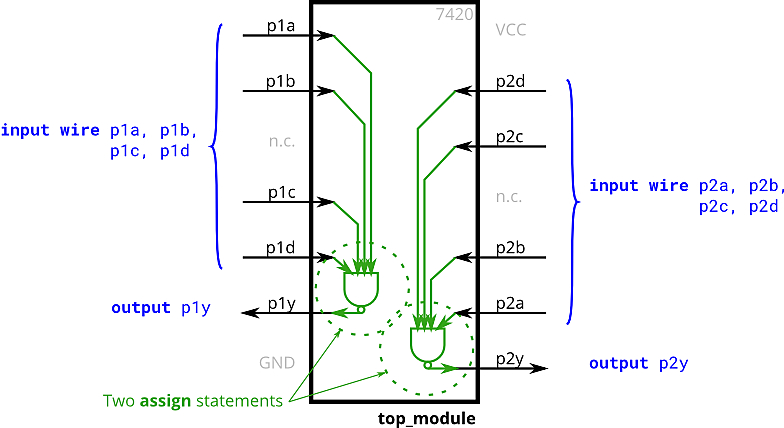

### Prompt from HDLBits
```verilog
//The 7400-series integrated circuits are a series of digital chips with a few gates each.
//The 7420 is a chip with two 4-input NAND gates.

// Create a module with the same functionality as the 7420 chip. It has 8 inputs and 2 outputs.

//Hint: You need to drive two signals (p1y and p2y) with a value.

module top_module (
    input p1a, p1b, p1c, p1d,
    output p1y,
    input p2a, p2b, p2c, p2d,
    output p2y );

    // Insert your code here

endmodule
```



In [ ]:
#@title Setting up files

%cd /content
!mkdir -p 7420_example
!curl -o ./7420_example/config.json https://raw.githubusercontent.com/JBlocklove/LLMs-for-EDA-Tutorial/fa108cb70fac7177a5382f3adf662e799527af49/demo_files/AutoChip/ETS/7420_example/config.json
!curl -o ./7420_example/7420.sv https://raw.githubusercontent.com/JBlocklove/LLMs-for-EDA-Tutorial/fa108cb70fac7177a5382f3adf662e799527af49/demo_files/AutoChip/ETS/7420_example/7420.sv
!curl -o ./7420_example/7420_tb.sv https://raw.githubusercontent.com/JBlocklove/LLMs-for-EDA-Tutorial/fa108cb70fac7177a5382f3adf662e799527af49/demo_files/AutoChip/ETS/7420_example/7420_tb.sv

In [ ]:
%cd /content/7420_example
from time import time
# Setting up the main function call
"""Main function to execute the program logic."""
config_values, ensemble_config, logfile = parse_args_and_config()

# Use the parsed values as needed
prompt_file = config_values['prompt']
module = config_values['name']
testbench = config_values['testbench']
family = config_values.get('model_family',None)
model_id = config_values.get('model_id', None)
iterations = config_values['iterations']
num_candidates = config_values['num_candidates']
outdir = config_values['outdir']
log = config_values['log']

with open(prompt_file, 'r') as file:
    prompt = file.read()

start_time = time()
max_response = verilog_loop(design_prompt=prompt, module=module, testbench=testbench, max_iterations = iterations, model_type=family, model_id=model_id, num_candidates=num_candidates, outdir=outdir, log=logfile, ensemble_config=ensemble_config)
end_time = time()
generation_time = end_time - start_time

try:
    with open(logfile, 'a') as file:
        file.write(f"Time to Generate: {generation_time}\n")
        file.write(f"Best ranked response at iteration {max_response.iteration} with response number {max_response.response_num}\n")
        file.write(f"Rank of best response: {max_response.rank}\n")
        file.write(f"Best response module:\n{max_response.parsed_text}\n")
except:
    pass

%cd /content

# Example 2: State Machine

## Arbiter Circuit
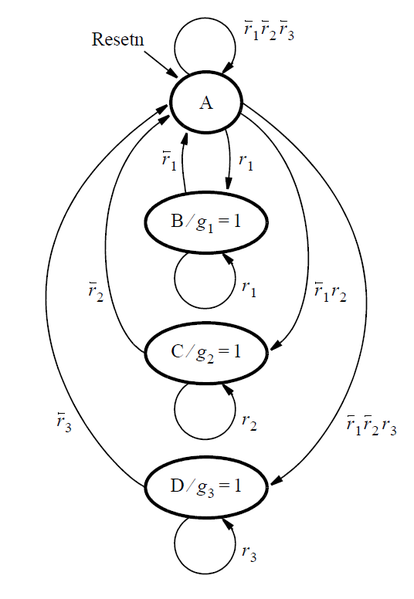

## Prompt from HDLBits
```verilog
// Consider the FSM described by the state diagram shown below:

// A --r1=0,r2=0,r3=0--> A
// A --r1=1--> B
// A --r1=0,r2=1--> C
// A --r1=0,r2=0,r3=0--> D
// B (g1=1) --r1=1--> B
// B (g1=1) --r1=0--> A
// C (g2=1) --r2=1--> C
// C (g2=1) --r2=0--> A

// Resetn is an active-low synchronous reset that resets into state A. This FSM acts as an arbiter circuit, which controls access to some type of resource by three requesting devices. Each device makes its request for the resource by setting a signal _r[i]_ = 1, where _r[i]_ is either _r[1]_, _r[2]_, or _r[3]_. Each r[i] is an input signal to the FSM, and represents one of the three devices. The FSM stays in state _A_ as long as there are no requests. When one or more request occurs, then the FSM decides which device receives a grant to use the resource and changes to a state that sets that device's _g[i]_ signal to 1. Each _g[i]_ is an output from the FSM. There is a priority system, in that device 1 has a higher priority than device 2, and device 3 has the lowest priority. Hence, for example, device 3 will only receive a grant if it is the only device making a request when the FSM is in state _A_. Once a device, _i_, is given a grant by the FSM, that device continues to receive the grant as long as its request, _r[i]_ = 1.

// Write complete Verilog code that represents this FSM. Use separate always blocks for the state table and the state flip-flops, as done in lectures. Describe the FSM outputs, _g[i]_, using either continuous assignment statement(s) or an always block (at your discretion). Assign any state codes that you wish to use.

module top_module (
	input clk,
	input resetn,
	input [3:1] r,
	output [3:1] g
);

```

In [ ]:
#@title Setting up files

%cd /content
!mkdir -p arbiter_example
!curl -o ./arbiter_example/config.json https://raw.githubusercontent.com/JBlocklove/LLMs-for-EDA-Tutorial/fa108cb70fac7177a5382f3adf662e799527af49/demo_files/AutoChip/ETS/arbiter_example/config.json
!curl -o ./arbiter_example/2013_q2afsm.sv https://raw.githubusercontent.com/JBlocklove/LLMs-for-EDA-Tutorial/fa108cb70fac7177a5382f3adf662e799527af49/demo_files/AutoChip/ETS/arbiter_example/2013_q2afsm.sv
!curl -o ./arbiter_example/2013_q2afsm_tb.sv https://raw.githubusercontent.com/JBlocklove/LLMs-for-EDA-Tutorial/fa108cb70fac7177a5382f3adf662e799527af49/demo_files/AutoChip/ETS/arbiter_example/2013_q2afsm_tb.sv


In [ ]:
%cd /content/arbiter_example
from time import time
# Setting up the main function call
"""Main function to execute the program logic."""
config_values, ensemble_config, logfile = parse_args_and_config()

# Use the parsed values as needed
prompt_file = config_values['prompt']
module = config_values['name']
testbench = config_values['testbench']
family = config_values.get('model_family',None)
model_id = config_values.get('model_id', None)
iterations = config_values['iterations']
num_candidates = config_values['num_candidates']
outdir = config_values['outdir']
log = config_values['log']

with open(prompt_file, 'r') as file:
    prompt = file.read()

start_time = time()
max_response = verilog_loop(design_prompt=prompt, module=module, testbench=testbench, max_iterations = iterations, model_type=family, model_id=model_id, num_candidates=num_candidates, outdir=outdir, log=logfile, ensemble_config=ensemble_config)
end_time = time()
generation_time = end_time - start_time

try:
    with open(logfile, 'a') as file:
        file.write(f"Time to Generate: {generation_time}\n")
        file.write(f"Best ranked response at iteration {max_response.iteration} with response number {max_response.response_num}\n")
        file.write(f"Rank of best response: {max_response.rank}\n")
        file.write(f"Best response module:\n{max_response.parsed_text}\n")
except:
    pass

%cd /content

# Example 3: "Confusing" Sequential logic

## Cellular Automation Rule 90

|Left|Center|Right|Center's Next State|
|----|------|-----|-------------------|
|1   |1     |1    |0                  |
|1   |1     |0    |1                  |
|1   |0     |1    |0                  |
|1   |0     |0    |1                  |
|0   |1     |1    |1                  |
|0   |1     |0    |0                  |
|0   |0     |1    |1                  |
|0   |0     |0    |0                  |

## HDLBits prompt
```verilog
// Rule 90 is a one-dimensional cellular automaton with interesting properties.

// The rules are simple. There is a one-dimensional array of cells (on or off). At each time step, the next state of each cell is the XOR of the cell's two current neighbours. A more verbose way of expressing this rule is the following table, where a cell's next state is a function of itself and its two neighbours:

// Left	Center	Right	Center's next state
// 1	1	1	0
// 1	1	0	1
// 1	0	1	0
// 1	0	0	1
// 0	1	1	1
// 0	1	0	0
// 0	0	1	1
// 0	0	0	0
// (The name "Rule 90" comes from reading the "next state" column: 01011010 is decimal 90.)


// In this circuit, create a 512-cell system (q[511:0]), and advance by one time step each clock cycle. The load input indicates the state of the system should be loaded with data[511:0]. Assume the boundaries (q[-1] and q[512]) are both zero (off).

// Hint: For an initial state of q[511:0] = 1, the first few iterations are:
//        1
//       10
//      101
//     1000
//    10100
//   100010
//  1010101
// 10000000
// This forms half of a Sierpiński triangle.

module top_module(
    input clk,
    input load,
    input [511:0] data,
    output [511:0] q );

    // Insert your code here

endmodule
```

In [ ]:
#@title Setting up files

%cd /content
!mkdir -p rule90_example
!curl -o ./rule90_example/config.json https://raw.githubusercontent.com/JBlocklove/LLMs-for-EDA-Tutorial/fa108cb70fac7177a5382f3adf662e799527af49/demo_files/AutoChip/ETS/rule90_example/config.json
!curl -o ./rule90_example/rule90.sv https://raw.githubusercontent.com/JBlocklove/LLMs-for-EDA-Tutorial/fa108cb70fac7177a5382f3adf662e799527af49/demo_files/AutoChip/ETS/rule90_example/rule90.sv
!curl -o ./rule90_example/rule90_tb.sv https://raw.githubusercontent.com/JBlocklove/LLMs-for-EDA-Tutorial/fa108cb70fac7177a5382f3adf662e799527af49/demo_files/AutoChip/ETS/rule90_example/rule90_tb.sv

In [ ]:
%cd /content/rule90_example
from time import time
# Setting up the main function call
"""Main function to execute the program logic."""
config_values, ensemble_config, logfile = parse_args_and_config()

# Use the parsed values as needed
prompt_file = config_values['prompt']
module = config_values['name']
testbench = config_values['testbench']
family = config_values.get('model_family',None)
model_id = config_values.get('model_id', None)
iterations = config_values['iterations']
num_candidates = config_values['num_candidates']
outdir = config_values['outdir']
log = config_values['log']

with open(prompt_file, 'r') as file:
    prompt = file.read()

start_time = time()
max_response = verilog_loop(design_prompt=prompt, module=module, testbench=testbench, max_iterations = iterations, model_type=family, model_id=model_id, num_candidates=num_candidates, outdir=outdir, log=logfile, ensemble_config=ensemble_config)
end_time = time()
generation_time = end_time - start_time

try:
    with open(logfile, 'a') as file:
        file.write(f"Time to Generate: {generation_time}\n")
        file.write(f"Best ranked response at iteration {max_response.iteration} with response number {max_response.response_num}\n")
        file.write(f"Rank of best response: {max_response.rank}\n")
        file.write(f"Best response module:\n{max_response.parsed_text}\n")
except:
    pass

%cd /content